# Aula 03
Aprendizado supervisionado: classificação

In [53]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
#desativar o warning de SettingWithCopyWarning - até encontrar um solução para df[:,[coluna]]
pd.options.mode.chained_assignment = None

In [54]:
link = 'https://raw.githubusercontent.com/FLS-6497/datasets/main/aula3/PKAP_raw_data.csv'
dados = pd.read_csv(link, encoding = "latin")



## a) Exploração de features
Faça gráficos de barras com a frequência da variável race por cada uma das variáveis officer_ na base de dados. O resultado deve indicar quantas vítimas de mortes por violência letal policial de diferentes raças (whites e blacks) ocorreram em diferentes categorias (e.g., office_offduty). Dica: algumas variáveis precisam ser recategorizadas porque possuem muitas categorias com poucas ocorrências.

In [55]:
#Seleciona apenas as colunas mencionadas
colunas = ['race']
colunas_officer = [coluna for coluna in dados.columns if coluna.startswith('officer')]
#Adiciona os itens a um lista
colunas.extend(colunas_officer)

dados_limpeza = dados[colunas]
dados_limpeza.head()

,race,officer_present,officer_fire,officer_name,officer_years,officer_gender,officer_race,officer_undercover,officer_offduty,officer_personal
0,White,Exact number provided. Enter number:,Exact number provided. Enter number:,Yes,No,Male. Number of officers:,Unknown,No,No,No
1,White,Exact number provided. Enter number:,Exact number provided. Enter number:,Yes,No,Unknown. Number of officers:,Unknown,No,No,No
2,White,Exact number provided. Enter number:,Exact number provided. Enter number:,Yes,Yes,Unknown. Number of officers:,Unknown,No,No,No
3,White,Exact number provided. Enter number:,Exact number provided. Enter number:,Yes,No,Unknown. Number of officers:,Unknown,No,No,No
4,White,Exact number provided. Enter number:,Exact number provided. Enter number:,No,Yes,Unknown. Number of officers:,Unknown,No,No,No


In [56]:
#Conta o número de valroes possiveis para cada coluna
for coluna in colunas: 
    print("\nVariavés unicas (" + coluna + "):", dados_limpeza[coluna].unique())



Variavés unicas (race): ['White' 'Black']

Variavés unicas (officer_present): ['Exact number provided. Enter number:' 'Unknown'
 'Exact number given. Enter number:']

Variavés unicas (officer_fire): ['Exact number provided. Enter number:' 'Unknown'
 'Exact number given. Enter number:']

Variavés unicas (officer_name): ['Yes' 'No']

Variavés unicas (officer_years): ['No' 'Yes']

Variavés unicas (officer_gender): ['Male. Number of officers:' 'Unknown. Number of officers:'
 'Male. Number of officers:,Unknown. Number of officers:'
 'Male. Number of officers:,Female. Number of officers:'
 'Female. Number of officers:'
 'Male. Number of officers: , Unknown. Number of officers:'
 'Female. Number of officers:,Unknown. Number of officers:'
 'Male. Number of officers:, Unknown. Number of officers:'
 'Male. Number of officers:, \tUnknown. Number of officers:'
 'Male. Number of officers:,Female. Number of officers:,Unknown. Number of officers:'
 'Female. Number of officers: , Unknown. Number of o

In [57]:
#Padroniza a variável officer_gender:
condicao = dados_limpeza['officer_gender'].str.startswith('Male').fillna(False)
dados_limpeza.loc[condicao,'officer_gender_alt'] = 'Male'
dados_limpeza.loc[~condicao,'officer_gender_alt'] = 'Female'

#Padroniza a variável officer_race
condicao = dados_limpeza['officer_race'].str.startswith('White').fillna(False)
dados_limpeza.loc[condicao,'officer_race_alt'] = 'White'
dados_limpeza.loc[~condicao,'officer_race_alt'] = 'Other'


#Padroniza variiáveis fire and present
for n in ['officer_fire','officer_present']:
    condicao = dados_limpeza[n].str.startswith("Unknown").fillna(False)
    nova_coluna = n + '_alt'
    dados_limpeza.loc[condicao,nova_coluna] = 'Unknown'
    dados_limpeza.loc[~condicao,nova_coluna] = 'Yes'
    

for n in ['officer_name','officer_years','officer_offduty','officer_personal','officer_undercover']:
    condicao = dados_limpeza[n].str.startswith("Yes").fillna(False)
    nova_coluna = n + '_alt'
    dados_limpeza[nova_coluna] = ""
    dados_limpeza.loc[condicao,nova_coluna] = 'Yes'
    dados_limpeza.loc[~condicao,nova_coluna] = 'No'
    

#colunas_alt = [coluna for coluna in colunas_alteradas]
#colunas_alt = ['race'].append(colunas_alt)
colunas_alteradas = [coluna for coluna in dados_limpeza.columns if coluna.endswith('_alt')]
colunas_selecionadas = ['race']
colunas_selecionadas.extend(colunas_alteradas)
dados_limpos = dados_limpeza[colunas_selecionadas]

In [58]:
dados_limpos_grafico = dados_limpos.melt(id_vars=['race'])
dados_limpos_grafico = dados_limpos_grafico.groupby(['race','variable','value'],as_index=False).value_counts()
#dados_limpos_grafico.rename({"count":"total"},inplace=True)
dados_limpos_grafico.head()

,race,variable,value,count
0,Black,officer_fire_alt,Unknown,41
1,Black,officer_fire_alt,Yes,199
2,Black,officer_gender_alt,Female,104
3,Black,officer_gender_alt,Male,136
4,Black,officer_name_alt,No,100


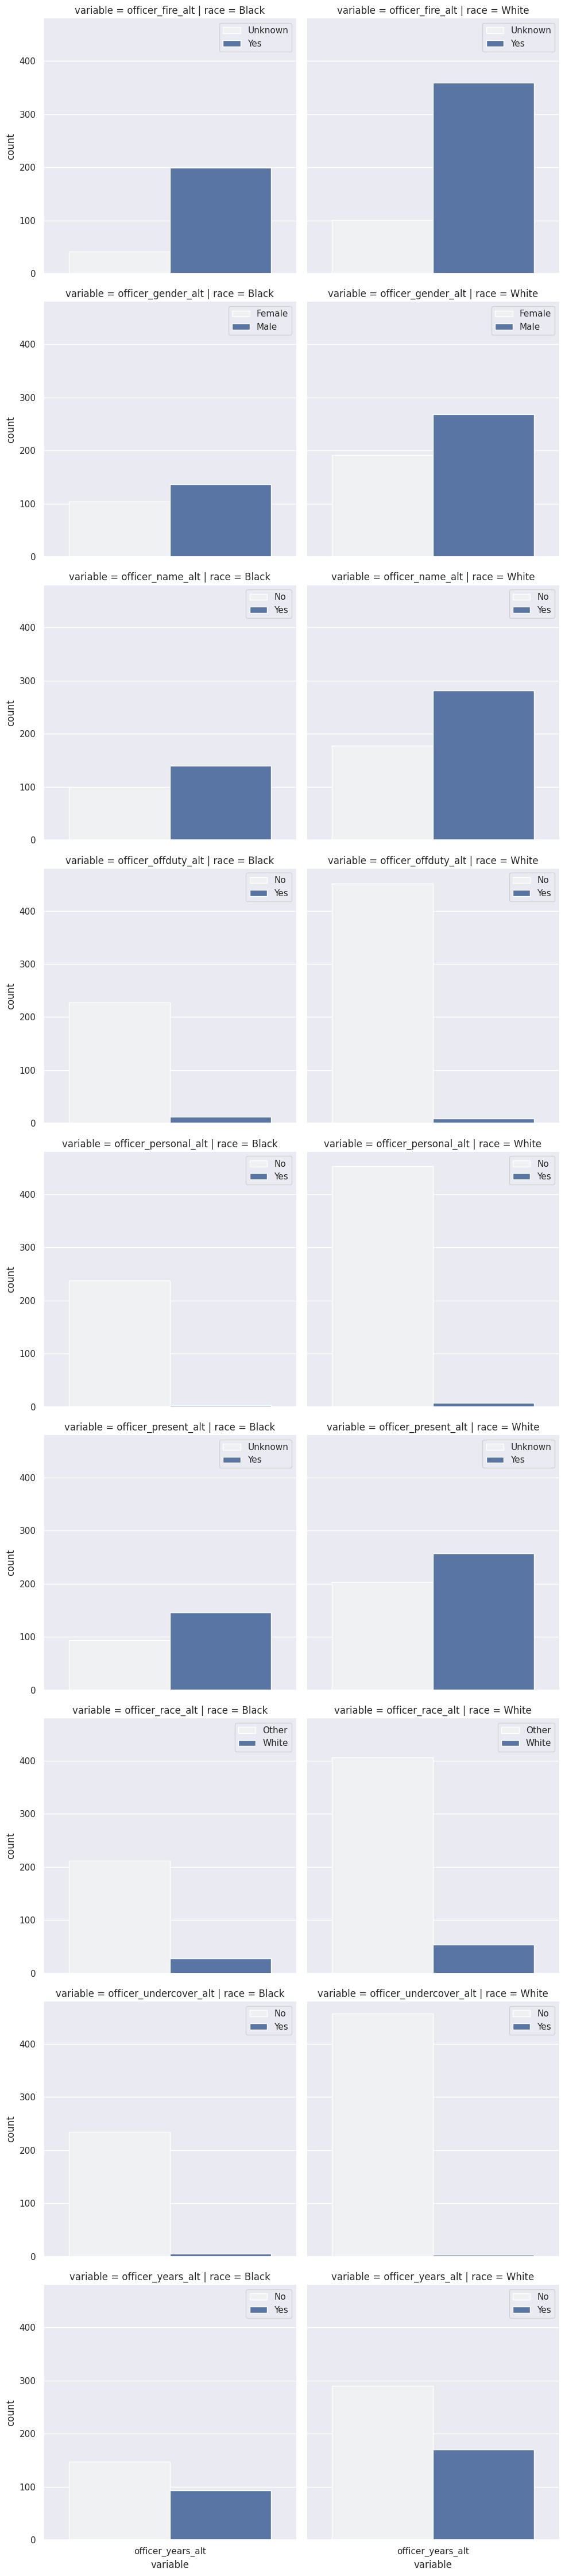

In [59]:
sns.set_theme(context='notebook')
#fig, axes = plt.subplots(2, 4, figsize=(18, 10))
g = sns.FacetGrid(dados_limpos_grafico,row='variable',col='race',height=5,legend_out=False)
g.mapdataframe(sns.barplot, x="variable", y='count',hue='value')
#g.map_dataframe(sns.countplot, x="variable", kind='count')
for ax in g.axes.ravel():
    ax.legend()


## b) Nova base
Crie uma nova base de dados que inclua apenas as variáveis mencionadas na Tabela 1 do paper de Streeter. Dica: será necessário criar novas variáveis e descartar outras existentes na base. Para quem usa Python, também é importante recodificar variáveis para o formato de one hot encoding (em R, a maioria das funções de regressão já faz essa conversão por baixo dos panos).


In [70]:
dados_artigo = dados[['age', 'gender', 'race', 'classification',
'armed', 'time', 'location', 'reason_contact',
'crime', 'behavior', 'witness', 'non_compliance',
'police_tactic', 'officer_race', 'swat', 'mental',
'deced_personal', 'deced_descrip', 'criminal_rec', 'violent_rec', 'officer_offduty']]


In [71]:
#primeiro grupo de variaveis - Mostrando apenas alterações
#print(dados_artigo['age'].describe())
dados_artigo['gender'].astype('category')
#print(dados_artigo['gender'].describe())
dados_artigo['race'].astype('category')
#print(dados_artigo['race'].astype('category').describe())

#print("\n")
dados_artigo['classification'].astype('category')
#print(dados_artigo['classification'].describe())
#print(dados_artigo['classification'].value_counts())
dados_artigo.loc[dados_artigo['classification'] != "Gunshot",'classification'] = 'Other'
print(dados_artigo['classification'].value_counts())



Gunshot    618
Other       82
Name: classification, dtype: int64


In [72]:
#Segundo grupo de variáveis
#dados_artigo['armed'].value_counts()
dados_artigo['armed'].astype('category')
#no artigo ela destaca outros tipos de armas

dados_artigo.loc[dados_artigo['time'] == 'Morning','time'] = "6:00 AM"
dados_artigo.loc[dados_artigo['time'] == 'Afternoon','time'] = "12:25 PM"
dados_artigo.loc[dados_artigo['time'] == 'Night','time'] = "6:00 PM"
dados_artigo.loc[dados_artigo['time'] == 'Night','time'] = "12:00 AM"
dados_artigo.loc[dados_artigo['time'] == 'Unknown','time'] = None

#dados_artigo['time'].strftime(format='%I:%M %p')
dados_artigo.loc[:,'time'] = pd.to_datetime(dados_artigo['time'],format='%I:%M %p',errors="coerce")
#dados_artigo[dados_artigo['time'] == NaT]
def criarPeriodo(hora):
    if hora >= 0 and hora < 6: 
        periodo = "0-6"
    elif hora >= 6 and hora < 12:
        periodo = "6-12"
    elif hora >= 12 and hora < 18:
        periodo = "12-18"
    elif hora >= 18 and hora < 24:
        periodo = "18-24"
    else: 
        periodo = "Unknown"
    return periodo

dados_artigo.loc[:,'time'] = dados_artigo['time'].dt.hour.apply(criarPeriodo)



In [73]:
dados_artigo['location'].astype('category')
dados_artigo['reason_contact'].astype('category')
dados_artigo.loc[dados_artigo['reason_contact'] != "Police responding to a reported offense by the victim","reason_contact"] = "Other"
#dados_artigo['reason_contact'].value_counts()
dados_artigo.loc[dados_artigo['crime'] != "None of the above",'crime'] = "Listed"
dados_artigo.loc[~dados_artigo['behavior'].isin(['Threatening behavior (armed)','None of the above']),'behavior'] = "Other"


condicao = dados_artigo['officer_race'].str.startswith('White').fillna(False)
dados_artigo.loc[condicao,'officer_race'] = 'White'
dados_artigo.loc[~condicao,'officer_race'] = 'Other'

# 'reason_contact',

In [74]:
for coluna in ['behavior', 'witness', 'non_compliance', 'police_tactic', 'swat', 'mental', 'officer_offduty',
'deced_personal', 'deced_descrip', 'criminal_rec', 'violent_rec']:
    dados_artigo[coluna].astype("category")
    #print(dados_artigo[coluna].describe())

condicao = dados_artigo['officer_offduty'].str.startswith("Yes").fillna(False)
dados_artigo.loc[condicao,'officer_offduty'] = 'Yes'
dados_artigo.loc[~condicao,'officer_offduty'] = 'No'



#como todas as variaveis são categoricas, optouse pela transformação em massa, para fins de exerciccio nem todas as variaveis serão corrigidas


# 2) Classificador logístico
Usando um framework (mlr3 ou sci-kit), treine um modelo logístico para predizer mortes de blacks (crie uma dummy indicando 1 para essa ocorrência) usando as variáveis anteriores.


In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Transforma as variaveis (precisam ser float)
Y = pd.get_dummies(dados_artigo['race']).Black
X = pd.get_dummies(dados_artigo['officer_offduty'])

# Treina o modelo
mod = LogisticRegression()
mod.fit(X, Y)

# Avalia predicoes
pred = mod.predict(X)
classification_report(Y, pred)
confusion_matrix(Y, pred)

array([[451,   9],
       [228,  12]])

# 3) Treino e teste
## a) Criar função
Crie uma função para sortear da base uma amostra de treino e, outra, de teste. Para isso, a função pode retornar uma lista com as duas amostras. Crie também um argumento na função que permita selecionar o percentual de observações na amostra de treino (o default precisará ser 0.7).

In [211]:
#transforma variaveis em dummies
def transformarVariaveis(base,variaveis):
    for var in variaveis:
        prefixo = var + "_"
        temp_x = pd.get_dummies(base[var],prefix=prefixo)
        dict_name = {}
        for nome_coluna in base[var].unique():
            dict_name[nome_coluna] = nome_coluna + '_' + var
        
        temp_x.rename(columns=dict_name, inplace=True)
        

        if 'final' in locals():
            final = pd.concat([final,temp_x],axis=1)
        else:
            final = temp_x
    return final


#seleciona amostra de acordo com o percentual de treino
def selecionarAmostra(base_Y,base_X, p_treino = 0.7, seed = 1):
    
    random.seed(seed)
    n_amostra = int(p_treino * (base_Y.shape[0] +1))
    #é necessario que a base de origem seja igual
    base_X_treino = base_X.sample(n_amostra)
    base_X_teste = base_X[~base_X.index.isin(base_X_treino.index)]
    base_Y_treino = base_Y[base_Y.index.isin(base_X_treino.index)]
    base_Y_teste = base_Y[~base_Y.index.isin(base_X_treino.index)]

    return seed, n_amostra, p_treino, base_Y_treino, base_Y_teste, base_X_treino, base_X_teste

def rodarModelo(seed, n_amostra, base_Y_treino, base_Y_teste, base_X_treino, base_X_teste, p_treino=0.7):
    # Treina o modelo
    mod = LogisticRegression()
    mod.fit(base_X_treino, base_Y_treino)

    # Avalia predicoes
    pred = mod.predict(base_X_teste)
    print("\n*****************************************************************")
    print("\nSeed: ",seed, " Amostra de treino: ",n_amostra, " Percentual de treino: ", p_treino)
    print("\nPrincipais indicadores:")
    print(classification_report(base_Y_teste, pred))
    print("\nMatriz de confusão: ")
    print(confusion_matrix(base_Y_teste, pred))
    print("\n*****************************************************************")
    acuracia = accuracy_score(base_Y_teste,pred)

    return acuracia


In [146]:
#primeiro é necessario trasnformar em dummy para depois separar em 

## b) Modelo com treino e teste
Com a função anterior, retreine seu modelo anterior na amostra de treino e, depois, aplique as predições na amostra de teste.

In [212]:
colunas_X = ['classification','armed', 'time', 'location', 'reason_contact', 'crime', 'behavior', 'witness', 'officer_race', 'swat', 'mental']
base_X = transformarVariaveis(dados_artigo,colunas_X)
base_Y = pd.get_dummies(dados_artigo['race']).Black

seed, n_amostra, p_treino, base_Y_treino, base_Y_teste, base_X_treino, base_X_teste = selecionarAmostra(base_Y, base_X)

modelo = rodarModelo(seed, n_amostra, base_Y_treino, base_Y_teste, base_X_treino, base_X_teste, p_treino=0.7)



*****************************************************************

Seed:  1  Amostra de treino:  490  Percentual de treino:  0.7

Principais indicadores:
              precision    recall  f1-score   support

           0       0.60      0.94      0.73       125
           1       0.47      0.08      0.14        85

    accuracy                           0.59       210
   macro avg       0.53      0.51      0.44       210
weighted avg       0.55      0.59      0.49       210


Matriz de confusão: 
[[117   8]
 [ 78   7]]

*****************************************************************


## c) Tamanho das amostras de treino
Com a função anterior, retreine seu modelo usando diferentes tamanhos de amostra de treino, de 0.3 a 0.9 com intervalos de 0.05. Crie um gráfico para reportar alguma métrica de validação (pode ser acurácia ou precisão, ou ainda F1) e, no eixo X, inclua a informação sobre o percentual usado



In [213]:
colunas_X = ['classification','armed', 'time', 'location', 'reason_contact', 'crime', 'behavior', 'witness', 'officer_race', 'swat', 'mental']
base_X = transformarVariaveis(dados_artigo,colunas_X)
base_Y = pd.get_dummies(dados_artigo['race']).Black

acuracia = []

for treino in np.arange(0.3,0.9,0.05):
    treino = round(treino,2)
    seed, n_amostra, p_treino, base_Y_treino, base_Y_teste, base_X_treino, base_X_teste = selecionarAmostra(base_Y, base_X, p_treino=treino)
    acc = rodarModelo(seed, n_amostra, base_Y_treino, base_Y_teste, base_X_treino, base_X_teste, p_treino=treino)

    acuracia.append([treino,acc])


*****************************************************************

Seed:  1  Amostra de treino:  210  Percentual de treino:  0.3

Principais indicadores:
              precision    recall  f1-score   support

           0       0.65      0.88      0.75       316
           1       0.41      0.16      0.23       174

    accuracy                           0.62       490
   macro avg       0.53      0.52      0.49       490
weighted avg       0.57      0.62      0.56       490


Matriz de confusão: 
[[277  39]
 [147  27]]

*****************************************************************

*****************************************************************

Seed:  1  Amostra de treino:  245  Percentual de treino:  0.35

Principais indicadores:
              precision    recall  f1-score   support

           0       0.62      0.86      0.72       288
           1       0.25      0.08      0.12       167

    accuracy                           0.57       455
   macro avg       0.43      0.4

[Text(0.5, 0, 'Treino'), Text(0, 0.5, 'Acurácia')]

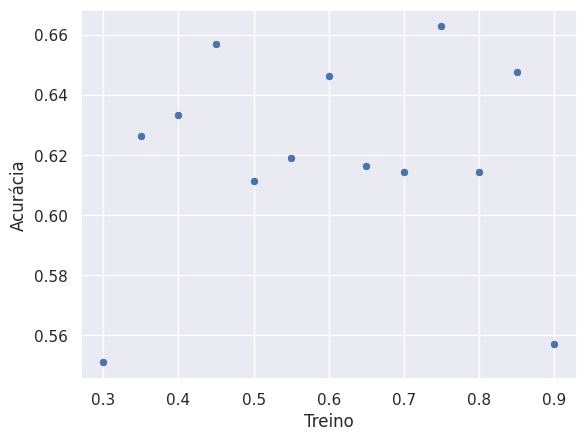

In [193]:
import seaborn as sns
acuracia = pd.DataFrame(acuracia)
acuracia.rename({0:"Treino", 1:"Acurácia"},inplace=True)
g = sns.scatterplot(x=acuracia[0],y=acuracia[1])
g.set(xlabel="Treino",ylabel='Acurácia')


# 4) Validação
## a) Nova função
Modifique a função criada anteriormente para que ela já separe a amostra em treino e teste, rode um modelo logístico e retorne alguma métrica de validação.

## b) Cross-validation
Use a função criada anteriormente para rodar 500 modelos logísticos em diferentes amostras de treino e de teste. Reporte os resultados desse exercício com um histograma dos valores de validação de alguma métrica.



In [219]:
def rodarModelo2(seed, n_amostra, base_Y_treino, base_Y_teste, base_X_treino, base_X_teste, p_treino=0.7):
    # Treina o modelo
    mod = LogisticRegression()
    mod.fit(base_X_treino, base_Y_treino)

    # Avalia predicoes
    pred = mod.predict(base_X_teste)
    acuracia = accuracy_score(base_Y_teste,pred)

    return acuracia

#para processar mais rápido, vamos tirar algumas colunas
colunas_X = ['classification','armed', 'time', 'location', 'witness', 'officer_race', 'swat']
base_X = transformarVariaveis(dados_artigo,colunas_X)
base_Y = pd.get_dummies(dados_artigo['race']).Black

acuracia = []

for n in range(1,501):
    
    seed, n_amostra, p_treino, base_Y_treino, base_Y_teste, base_X_treino, base_X_teste = selecionarAmostra(base_Y, base_X, p_treino=0.7,seed = random.randint(1,100000))
    acc = rodarModelo2(seed, n_amostra, base_Y_treino, base_Y_teste, base_X_treino, base_X_teste, p_treino=treino)

    acuracia.append([n,acc,seed])


[Text(0.5, 0, 'Acurácia')]

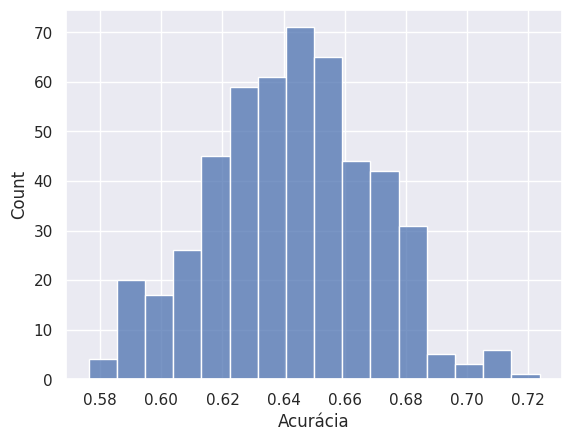

In [221]:
import seaborn as sns
acuracia = pd.DataFrame(acuracia)
#acuracia.rename({0:"Modelo", 1:"Acurácia"},inplace=True)
g = sns.histplot(x=acuracia[1])
g.set(xlabel='Acurácia')


# 5) Comparação de modelos
Adapte a função criada anteriormente para rodar um outro modelo de classificação binário, como naive bayes ou K-Nearest Neighbors (explore a documentação dos frameworks para descobrir outras opções e saber mais). Com esse novo modelo, rode 500 vezes e compare os resultados com o do modelo logístico criado anteriormente.